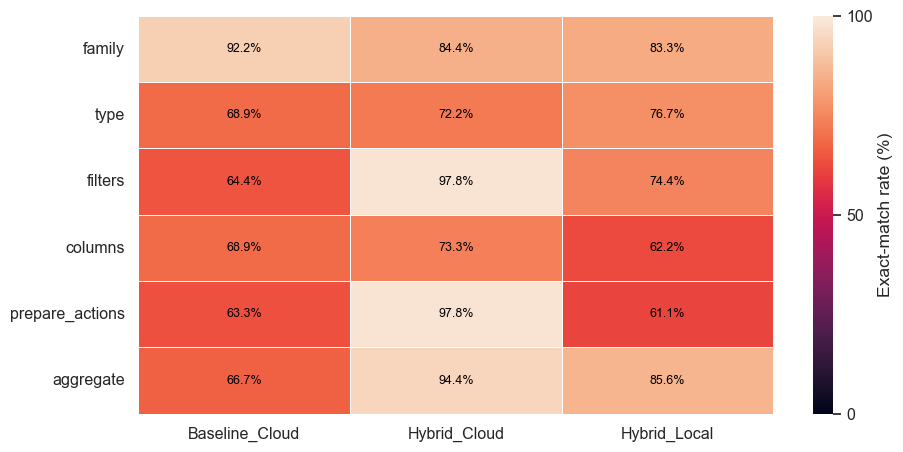

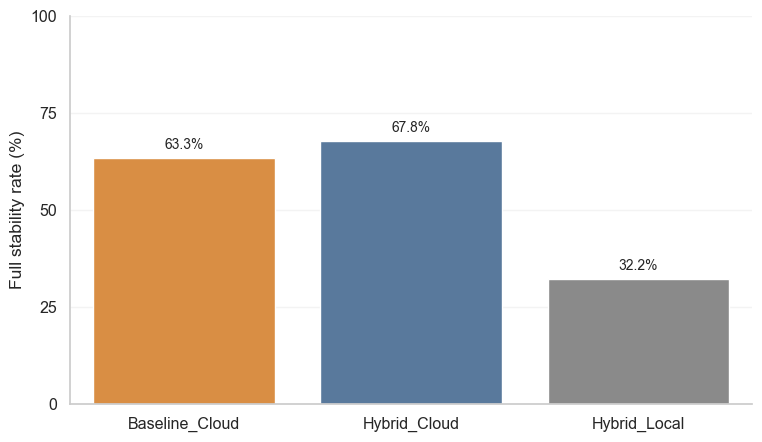

In [8]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import json
import ast
from pathlib import Path

# ---------- Vector PDF settings (LaTeX-friendly) ----------
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["svg.fonttype"] = "none"

MIN_N = 30
systems_order = ["Baseline_Cloud", "Hybrid_Cloud", "Hybrid_Local"]
components_order = ["family", "type", "filters", "columns", "prepare_actions", "aggregate"]

palette = {
    "Baseline_Cloud": "#F28E2B",
    "Hybrid_Cloud":   "#4E79A7",
    "Hybrid_Local":   "#8A8A8A",
}

sns.set_theme(
    style="whitegrid",
    font_scale=1.05,
    rc={"axes.spines.top": False, "axes.spines.right": False, "grid.alpha": 0.22},
)

# -------------------------
# INPUT paths (stability study excels)
# -------------------------
paths = {
    "Baseline_Cloud": r"...\experiments\stability study\stability_baseline_cloud.xlsx",
    "Hybrid_Cloud":   r"...\experiments\stability study\stability_hybrid_cloud.xlsx",
    "Hybrid_Local":   r"...\experiments\stability study\stability_hybrid_local.xlsx",
}

# -------------------------
# OUTPUT directory (your thesis Figures folder)
# -------------------------
out_dir = Path(r"...")
out_dir.mkdir(parents=True, exist_ok=True)

# -------------------------
# Helpers: IO + plotting
# -------------------------
def read_stability_xlsx(path: str) -> pd.DataFrame:
    """Try 'Tabular Data only' first, else fall back to first sheet."""
    xl = pd.ExcelFile(path)
    if "Tabular Data only" in xl.sheet_names:
        return pd.read_excel(path, sheet_name="Tabular Data only")
    return pd.read_excel(path, sheet_name=xl.sheet_names[0])

def agg_rate(df, group_cols, value_col):
    # observed=False silences pandas FutureWarning and keeps current behavior
    return df.groupby(group_cols, as_index=False, observed=False).agg(
        rate=(value_col, "mean"),
        n=(value_col, "size")
    )

def fmt_pct(x):
    return f"{x:.1f}%"

def common_n_or_none(df, col):
    ns = df.groupby("system", observed=False)[col].size()
    if len(set(ns.values)) == 1:
        return int(ns.values[0])
    return None

# -------------------------
# Helpers: "meaning-equal" canonicalization
# -------------------------
def _is_na(x):
    try:
        return pd.isna(x)
    except Exception:
        return x is None

def _as_python_obj(x):
    if _is_na(x):
        return None
    if isinstance(x, (dict, list, tuple, set)):
        return x
    if isinstance(x, (int, float, bool, np.integer, np.floating)):
        return x

    s = str(x).strip()
    if not s:
        return ""

    try:
        return json.loads(s)
    except Exception:
        pass

    try:
        return ast.literal_eval(s)
    except Exception:
        return s

def _norm_str(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

def _freeze(obj):
    if obj is None:
        return None
    if isinstance(obj, str):
        return _norm_str(obj)
    if isinstance(obj, dict):
        return tuple(sorted((_norm_str(str(k)), _freeze(v)) for k, v in obj.items()))
    if isinstance(obj, (list, tuple, set)):
        return tuple(sorted(_freeze(x) for x in obj))
    return obj

def normalize_decision(component: str, x):
    if _is_na(x):
        return None

    obj = _as_python_obj(x)

    # columns: treat comma-separated as an unordered set
    if isinstance(obj, str) and component == "columns":
        parts = [p.strip() for p in obj.split(",") if p.strip()]
        if len(parts) >= 2:
            return tuple(sorted(_norm_str(p) for p in parts))

    # family/type: simple normalized string
    if component in {"family", "type"} and isinstance(obj, str):
        return _norm_str(obj)

    return _freeze(obj)

def equivalent(component: str, a, b) -> bool:
    if _is_na(a) and _is_na(b):
        return True
    return normalize_decision(component, a) == normalize_decision(component, b)

# ============================================================
# 1) Load & build df_stability (per-prompt stability, n=30 per system)
# ============================================================
dfs = []
for sys, p in paths.items():
    d = read_stability_xlsx(p).copy()
    d["system"] = sys
    dfs.append(d)

df_raw = pd.concat(dfs, ignore_index=True)

if "id" in df_raw.columns and "ID" not in df_raw.columns:
    df_raw = df_raw.rename(columns={"id": "ID"})

raw_components = ["family", "type", "filters", "columns", "prepare", "aggregate"]

df_raw["variant"] = df_raw["variant"].astype(str)
is_base = df_raw["variant"].str.lower().eq("base")

base = df_raw[is_base].copy()
alts = df_raw[~is_base].copy()

key = ["system", "ID"]
base_keep = base[key + raw_components].rename(columns={c: f"{c}_base" for c in raw_components})
alts = alts.merge(base_keep, on=key, how="left", validate="many_to_one")

for c in raw_components:
    alts[f"match_{c}"] = alts.apply(lambda row: float(equivalent(c, row[c], row[f"{c}_base"])), axis=1)

alts["match_all_components"] = alts[[f"match_{c}" for c in raw_components]].min(axis=1)

df_stability = alts.groupby(key, as_index=False, observed=False).agg(
    match_family=("match_family", "mean"),
    match_type=("match_type", "mean"),
    match_filters=("match_filters", "mean"),
    match_columns=("match_columns", "mean"),
    match_prepare=("match_prepare", "mean"),
    match_aggregate=("match_aggregate", "mean"),
    match_all_components=("match_all_components", "mean"),
)

df_stability["system"] = pd.Categorical(df_stability["system"], categories=systems_order, ordered=True)

# ============================================================
# Plot A: Heatmap of exact-match rate by component × system (NO TITLE)
# ============================================================
comp_map = {
    "family": "match_family",
    "type": "match_type",
    "filters": "match_filters",
    "columns": "match_columns",
    "prepare_actions": "match_prepare",
    "aggregate": "match_aggregate",
}

comp_long = []
for comp in components_order:
    col = comp_map[comp]
    comp_long.append(
        df_stability[["system", col]]
        .rename(columns={col: "match"})
        .assign(component=comp)
    )
comp_long = pd.concat(comp_long, ignore_index=True)
comp_long["component"] = pd.Categorical(comp_long["component"], categories=components_order, ordered=True)
comp_long["system"] = pd.Categorical(comp_long["system"], categories=systems_order, ordered=True)

heat = agg_rate(comp_long, ["component", "system"], "match")
heat = heat[heat["n"] >= MIN_N].copy()
heat["rate_pct"] = heat["rate"] * 100

rate_piv = heat.pivot(index="component", columns="system", values="rate_pct").reindex(components_order)
rate_piv = rate_piv.loc[:, [s for s in systems_order if s in rate_piv.columns]]

fig, ax = plt.subplots(figsize=(9.6, 4.7))
sns.heatmap(
    rate_piv, ax=ax, vmin=0, vmax=100,
    cmap=None,
    linewidths=0.6, linecolor="white",
    cbar_kws={"label": "Exact-match rate (%)", "ticks": [0, 50, 100]},
)

for i, comp in enumerate(rate_piv.index):
    for j, sys in enumerate(rate_piv.columns):
        v = rate_piv.loc[comp, sys]
        if pd.notna(v):
            ax.text(j + 0.5, i + 0.5, fmt_pct(float(v)),
                    ha="center", va="center", fontsize=9, color="black")

ax.set_title("")  # <-- no title
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()

# SAVE (vector PDF)
fig.savefig(out_dir / "component_system_exact_match_heatmap.pdf", bbox_inches="tight")

plt.show()
# plt.close(fig)  # optional

# ============================================================
# Plot B: Full stability rate (all components match) by system (NO TITLE)
# ============================================================
full = df_stability.groupby("system", as_index=False, observed=False).agg(
    rate=("match_all_components", "mean"),
    n=("match_all_components", "size"),
)
full = full[full["n"] >= MIN_N].copy()
full["rate_pct"] = full["rate"] * 100
full["system"] = pd.Categorical(full["system"], categories=systems_order, ordered=True)
full = full.sort_values("system")

n_common = common_n_or_none(df_stability, "match_all_components")

fig, ax = plt.subplots(figsize=(7.8, 4.6))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    sns.barplot(
        data=full,
        x="system",
        y="rate_pct",
        order=systems_order,
        hue="system", hue_order=systems_order,
        palette=palette,
        dodge=False,
        ax=ax,
        edgecolor="white",
    )

leg = ax.get_legend()
if leg is not None:
    leg.remove()

ax.set_ylim(0, 100)
ax.set_yticks([0, 25, 50, 75, 100])
ax.set_ylabel("Full stability rate (%)")
ax.set_xlabel("")
ax.set_title("")  # <-- no title

full_sorted = full.set_index("system").loc[[s for s in systems_order if s in full["system"].values]].reset_index()
for i, r in full_sorted.iterrows():
    ax.text(i, float(r["rate_pct"]) + 1.5, fmt_pct(float(r["rate_pct"])),
            ha="center", va="bottom", fontsize=10)

if n_common is None:
    n_text = "\n".join([f"{row.system}: n={int(row.n)}" for row in full_sorted.itertuples()])
    ax.text(
        0.98, 0.02, n_text,
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="0.8", alpha=0.9)
    )

plt.tight_layout()

# SAVE (vector PDF)
fig.savefig(out_dir / "full_stability_rate_by_system.pdf", bbox_inches="tight")

plt.show()
# plt.close(fig)  # optional